## Q2: Conduct a customer segmentation for the wholesale distributor dataset.

* Student ID: p233340 
* Name: Kwok Tsz Yi
* Course: COM6101 

In [18]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# import dataset
import pandas as pd
df = pd.read_csv('Q2.csv')
df.head()

,CustID,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1,online,Shenzhen,12669,9656,7561,214,2674.0,1338
1,2,online,Shenzhen,7057,9810,9568,1762,3293.0,1776
2,3,online,Shenzhen,6353,8808,7684,2405,3516.0,7844
3,4,offline,Shenzhen,13265,1196,4221,6404,507.0,1788
4,5,online,Shenzhen,22615,5410,7198,3915,1777.0,5185


## Data Preprocessing

Size of the dataset:

In [19]:
df.shape

(440, 9)

Data types of the dataset:

In [20]:
df.dtypes

CustID                int64
Channel              object
Region               object
Fresh                object
Milk                  int64
Grocery               int64
Frozen                int64
Detergents_Paper    float64
Delicatessen          int64
dtype: object

As the CustID is not useful for the clustering, this column will be dropped.

In [21]:
df = df.drop(['CustID'], axis=1)

For column Fresh, it should be a numerical value, but pandas read it as an object. Transform it to numerical value.

In [22]:
# there is a strange value in df['Fresh'], which equals to ab9
df['Fresh'][df['Fresh'] == 'ab9']

66    ab9
Name: Fresh, dtype: object

In [23]:
# remove the strange value
df = df[df['Fresh'] != 'ab9']
df["Fresh"] = df["Fresh"].astype('int')

Missing values in the dataset:

In [24]:
# find rows with missing values
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    1
Delicatessen        0
dtype: int64

Handle the only missing value in the dataset: fill in the Detergents_Paper NaN with median value.

In [25]:
median_detergents_paper = df['Detergents_Paper'].median()
df['Detergents_Paper'] = df['Detergents_Paper'].fillna(median_detergents_paper)
df.isnull().sum() # check if the missing values are filled

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

### Data Preprocessing: Outlier Detection and Removal

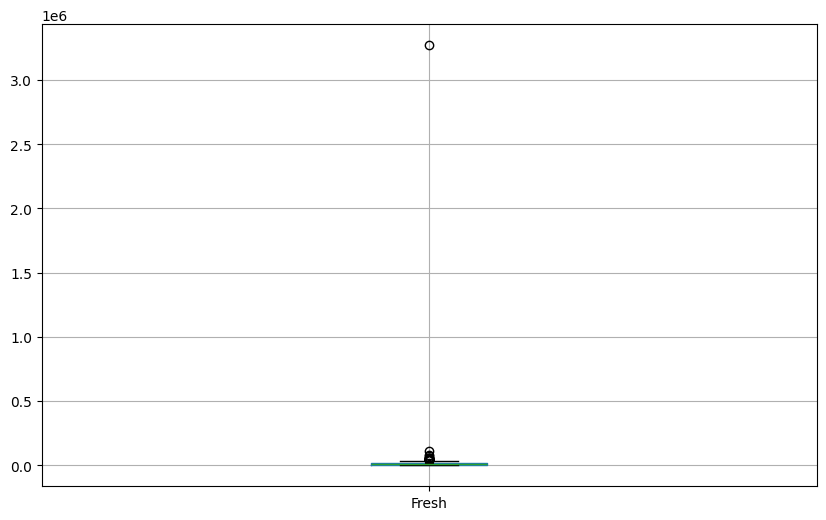

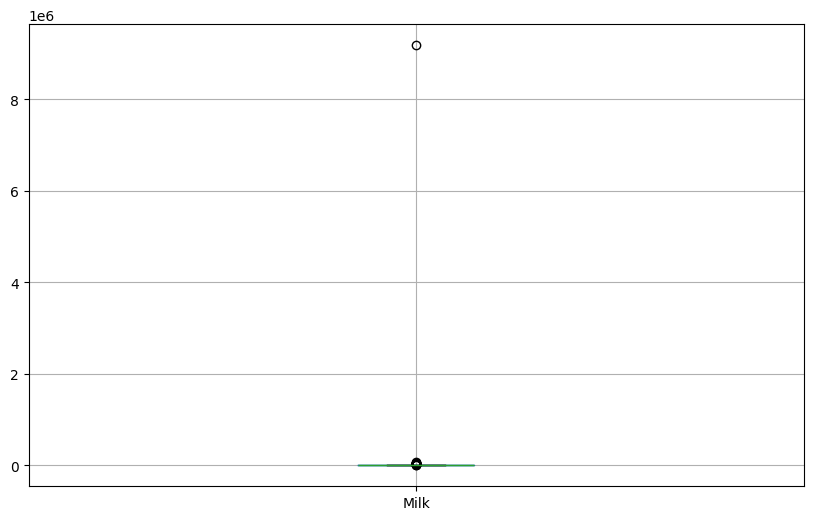

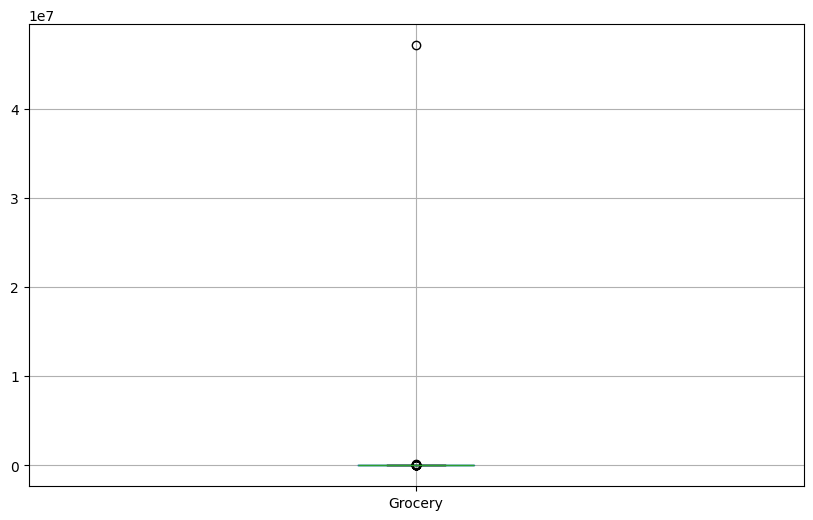

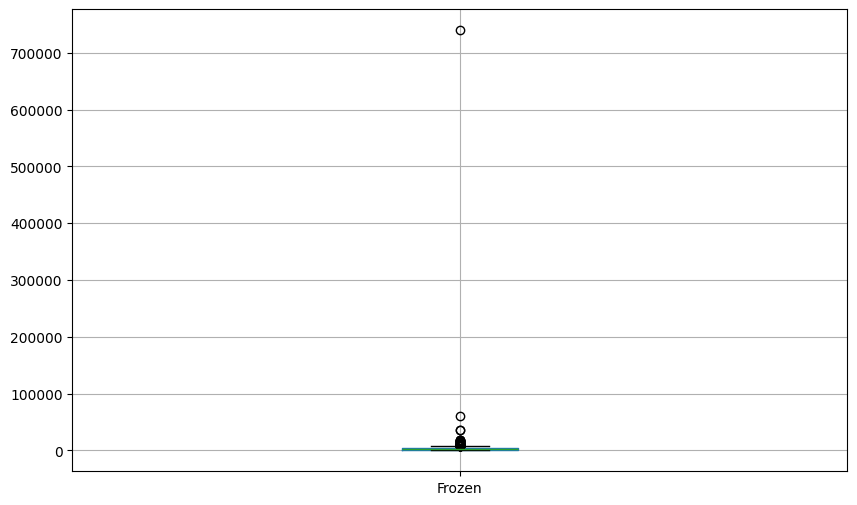

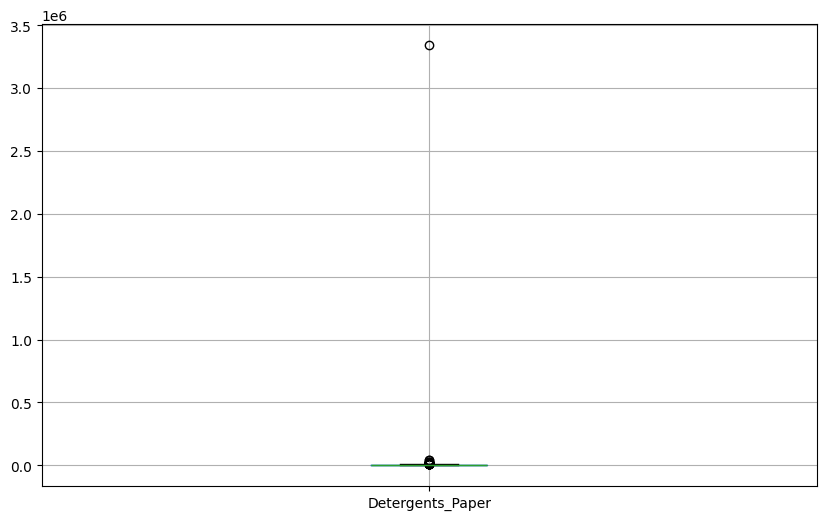

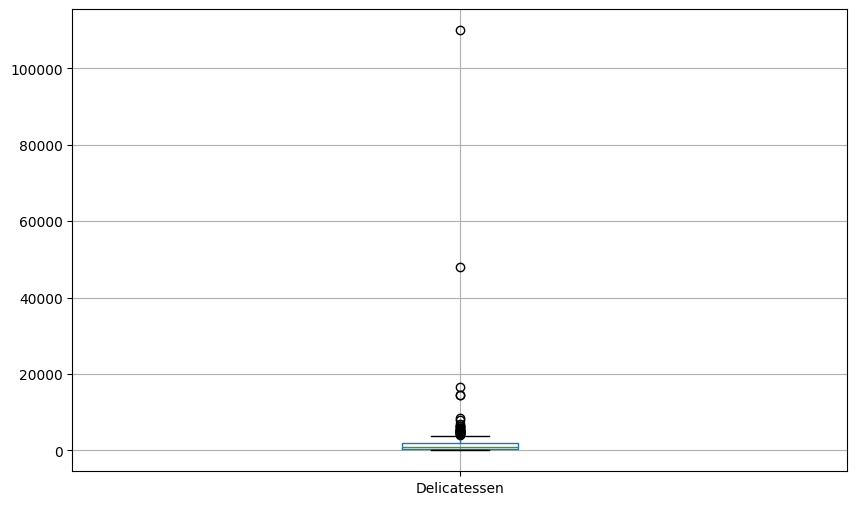

In [26]:
# use boxplot to visualize the distribution of each product
for i in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 6))
    df.boxplot(column=i)
    plt.show()

As per the boxplot, there are extreme values in the dataset, the customer clustering results will be affected by these outliers. Therefore, the outliers will be removed from the dataset.

In [27]:
# define extreme values as the 95th percentile of each product
# find outliers in numerical columns
df_1 = df.select_dtypes(include='number') # exclude non-numeric columns first
extreme_Q = df_1.quantile(0.95, numeric_only=True)
extreme_value = df_1[(df_1 > extreme_Q)]
extreme_value.count().sum()

132

There are 110 extreme values in the dataset, these extreme values will be replaced by 0.95 quantile value.

As per the above analysis, we can see that due to one particular extreme value in the Grocery Sales of SZ, the mean of the Grocery Sales is significantly higher than the median. Therefore, we can consider this as an outlier and remove it from the dataset.

In [28]:
# set the maximum value to the 95th percentile
df_1 = df_1.apply(lambda x: x.clip(upper=x.quantile(0.95)))
extreme_Q = df_1.quantile(0.95, numeric_only=True)
extreme_value = df_1[(df_1 > extreme_Q)]
# apply the clip function to the original dataframe
df[df_1.columns] = df_1
# check if in the original dataframe, the maximum value of each column is the 95th percentile
df[df_1.columns].max()

Fresh               36865.9
Milk                18041.2
Grocery             24714.5
Frozen              10017.3
Detergents_Paper    12237.0
Delicatessen         4646.3
dtype: float64

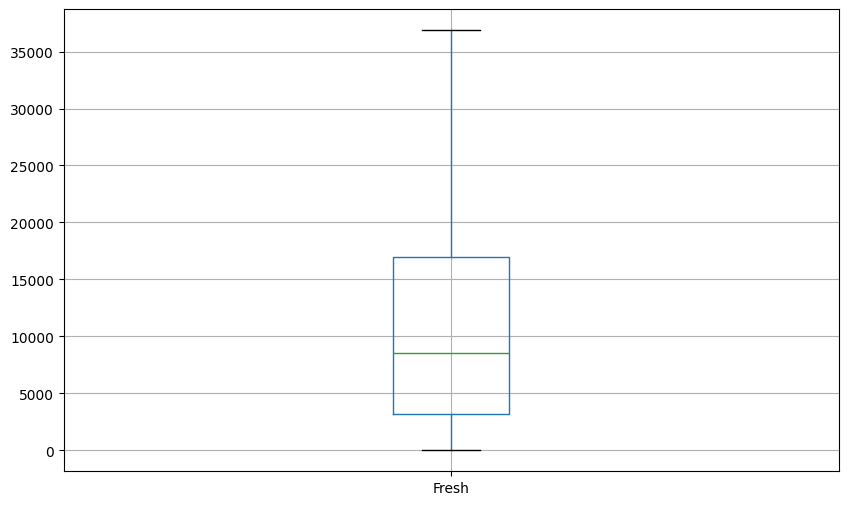

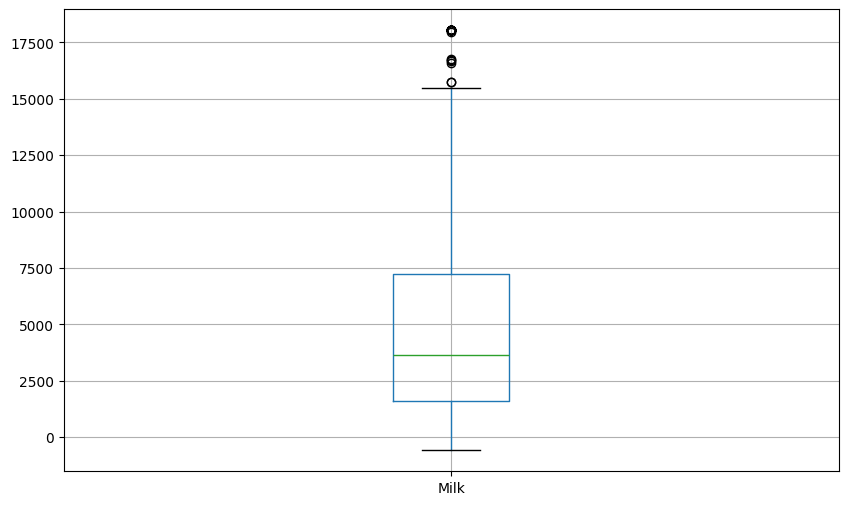

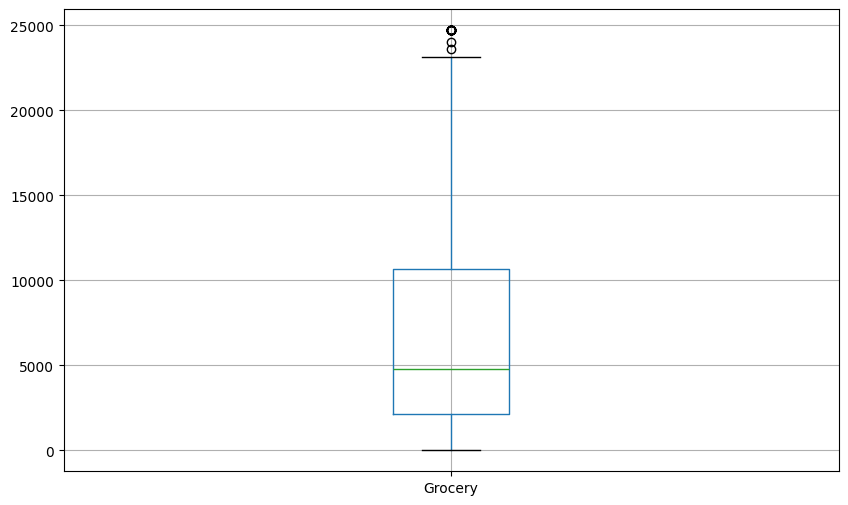

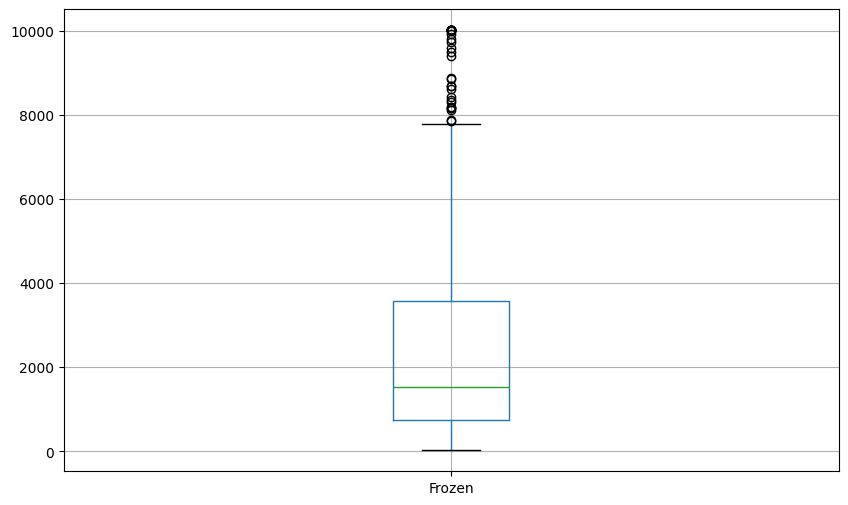

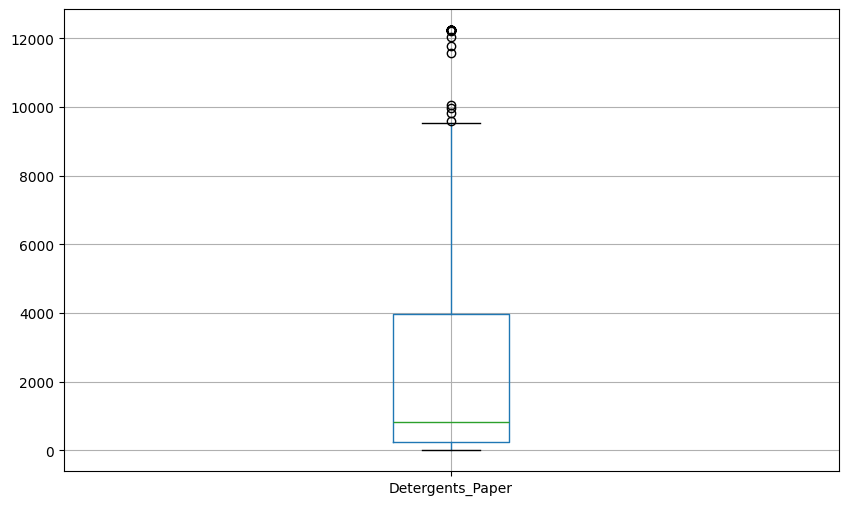

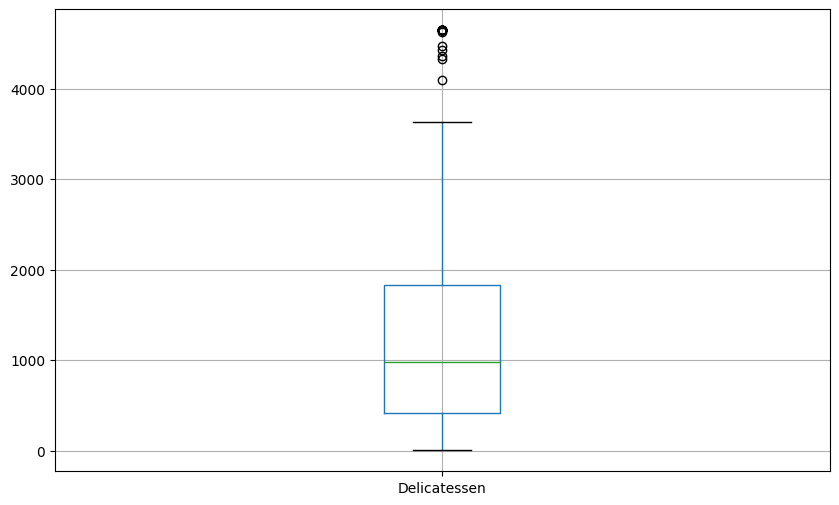

In [29]:
# observe the data distribution with boxplot
for i in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 6))
    df.boxplot(column=i)
    plt.show()

## Exploratory Data Analysis

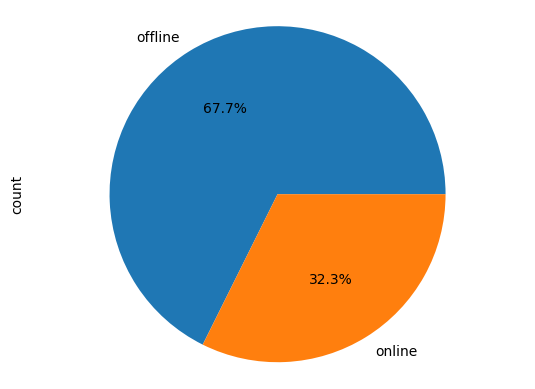

In [30]:
# pie chart for categorical data
import matplotlib.pyplot as plt
df['Channel'].value_counts().plot.pie(autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Most customers purchase from the offline channel, with only about 30% of the customers purchasing from the online channel.

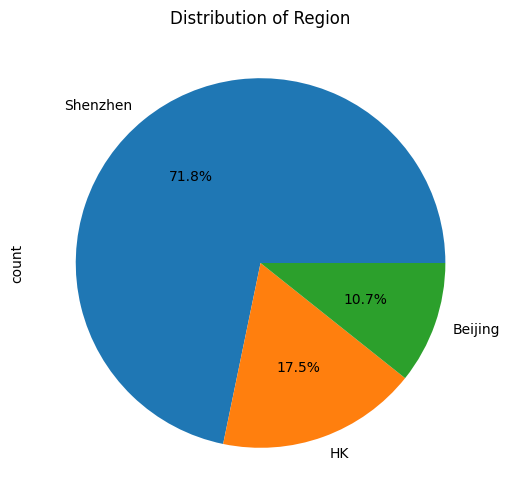

In [31]:
# pie chart for the distribution of the region
plt.figure(figsize=(10, 6))
df['Region'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Region')
plt.show()

For the regional distribution, the majority of the customers are from Shenzen, followed by Hong Kong and Beijing.

## Clustering Analysis

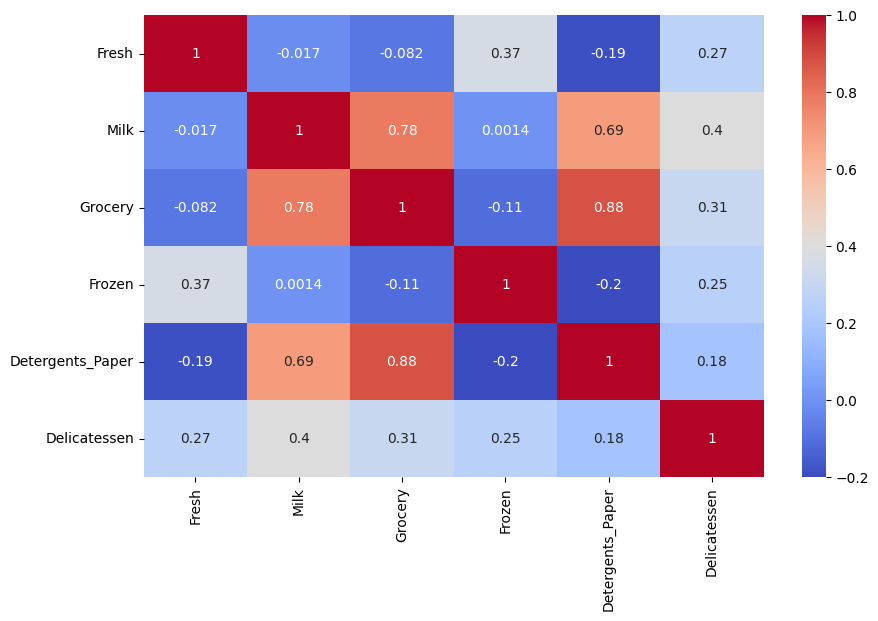

In [32]:
import seaborn as sns
# take a look at the correlation heatmap first, exclude the non-numeric columns and the CustID
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

Text(0, 0.5, 'WCSS')

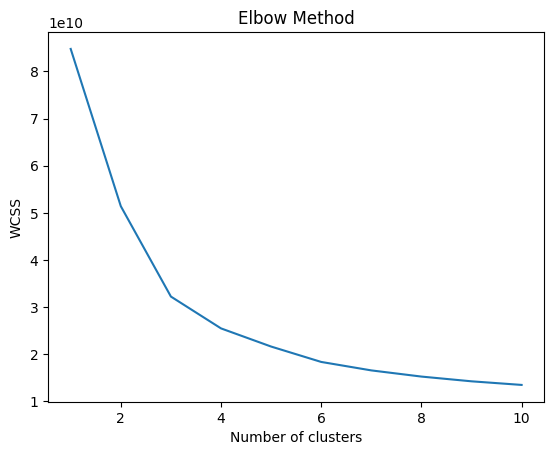

In [33]:
# use the elbow method to find the optimal number of clusters
X = df.select_dtypes(include='number')
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

As per the Elbow Method, the turning point is either at k = 2 or k = 3, hence we will choose k = 2 or k = 3 for the clustering analysis.

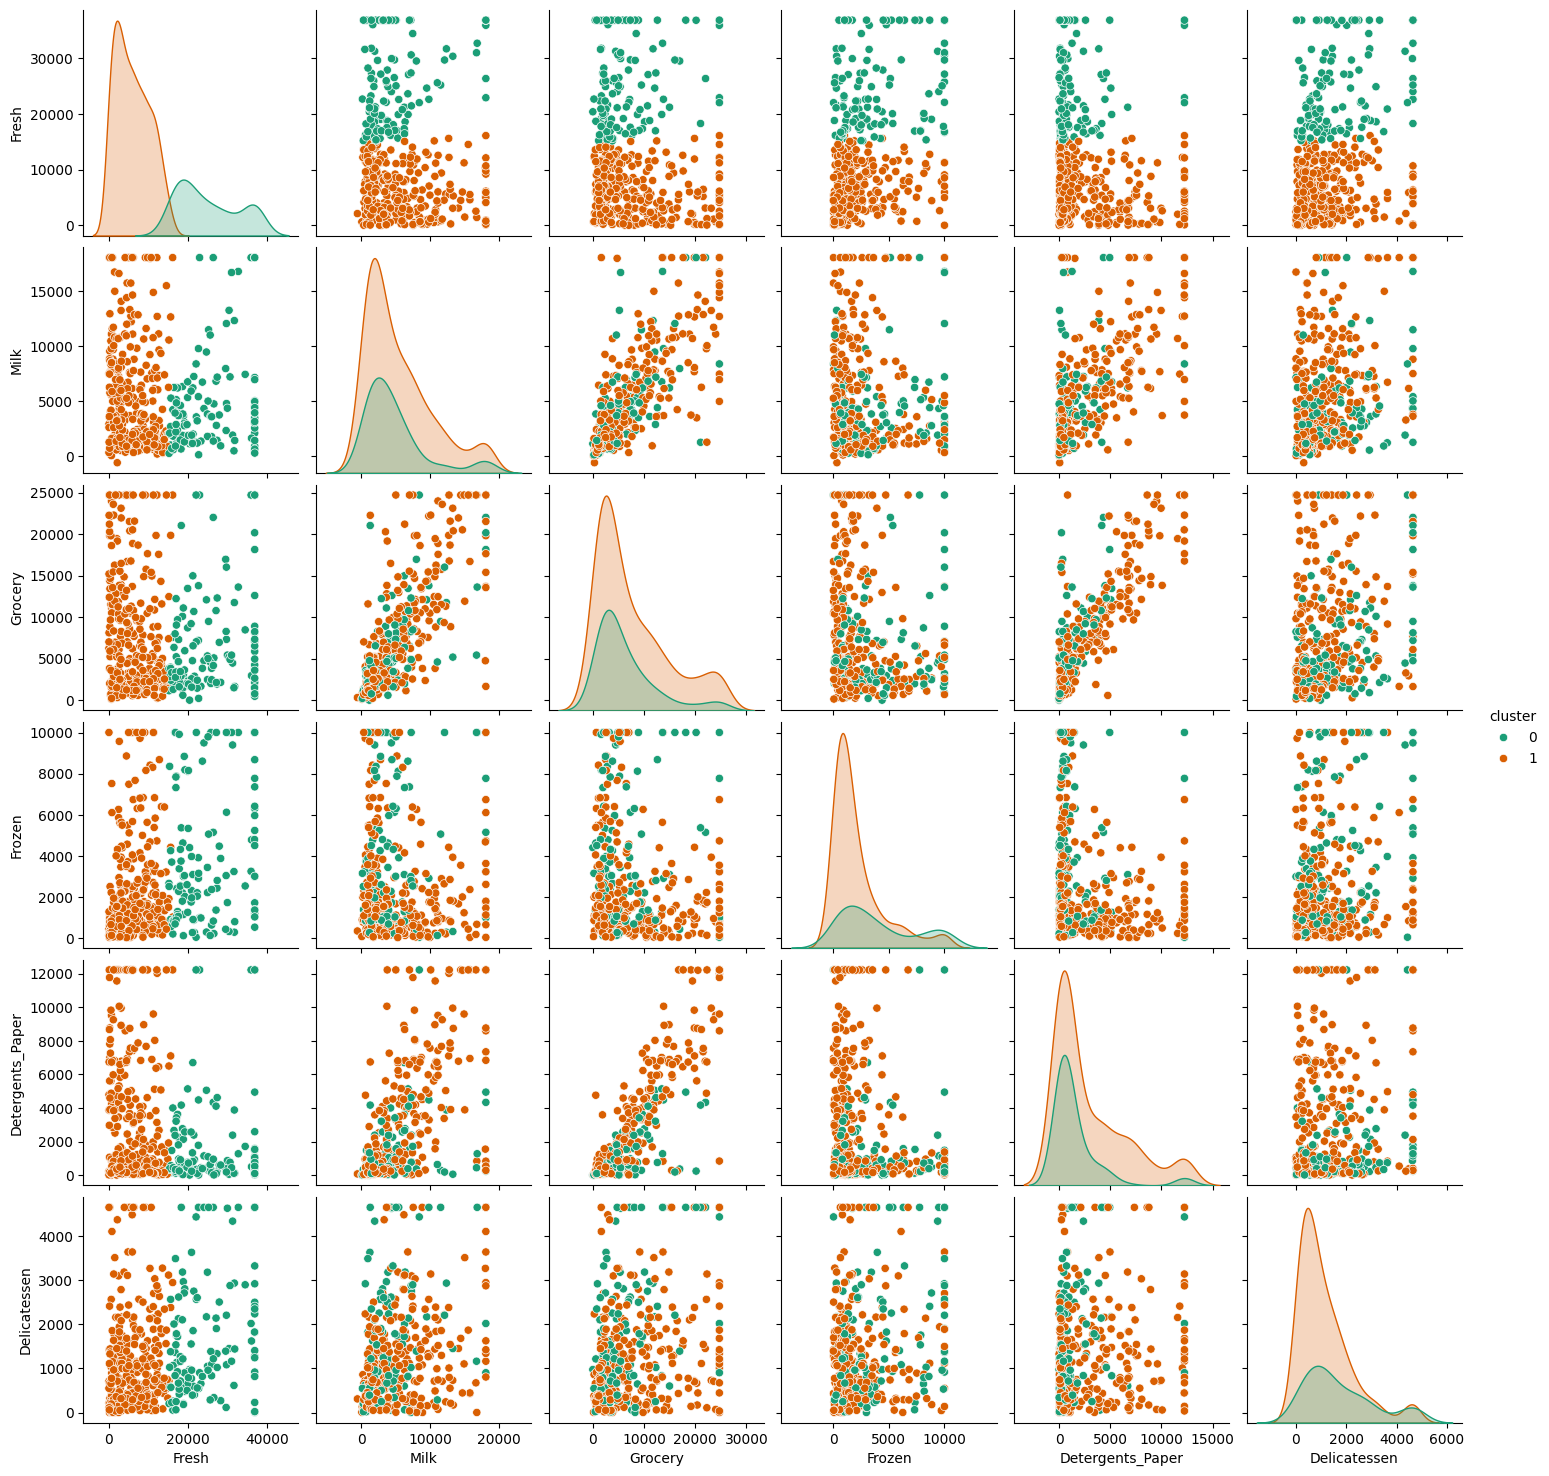

In [34]:
# use 2 clusters to fit the model
kmeans_2 = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans_2 = kmeans_2.fit_predict(X)

# plot a pairplot to visualize the clusters
df_2 = df.copy()
df_2['cluster'] = y_kmeans_2
sns.pairplot(df_2, hue='cluster', palette='Dark2')

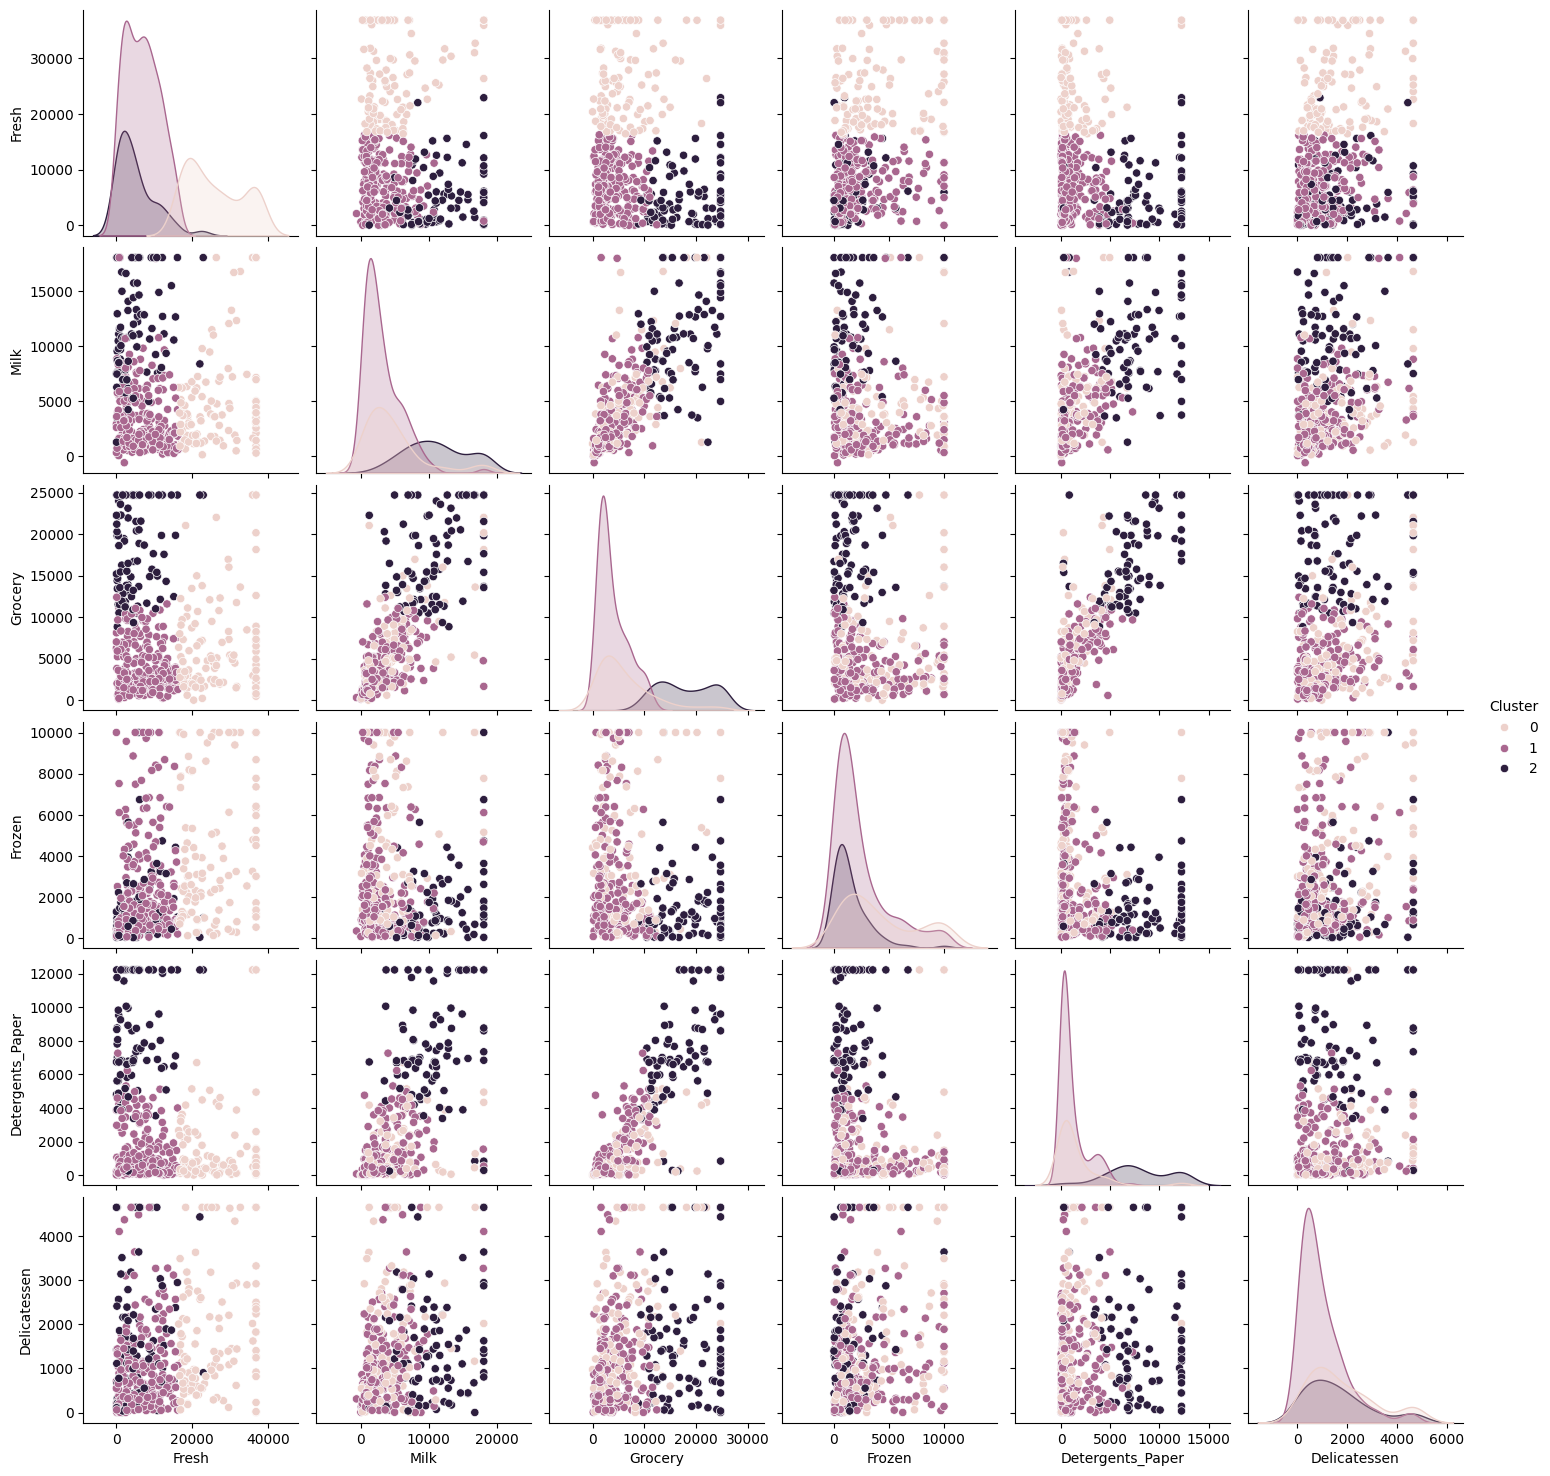

In [35]:
# use 3 clusters to fit the data
kmeans_3 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans_3 = kmeans_3.fit_predict(X)

# plot a pairplot to visualize the clusters
df_3 = df.copy()
df_3['Cluster'] = y_kmeans_3
sns.pairplot(df_3, hue='Cluster')

For n_clusters = 2, the average silhouette_score is : 0.39829546318956227
For n_clusters = 3, the average silhouette_score is : 0.41101747014819345
For n_clusters = 4, the average silhouette_score is : 0.340733774473351
For n_clusters = 5, the average silhouette_score is : 0.344694202502736
For n_clusters = 6, the average silhouette_score is : 0.33698701902265654


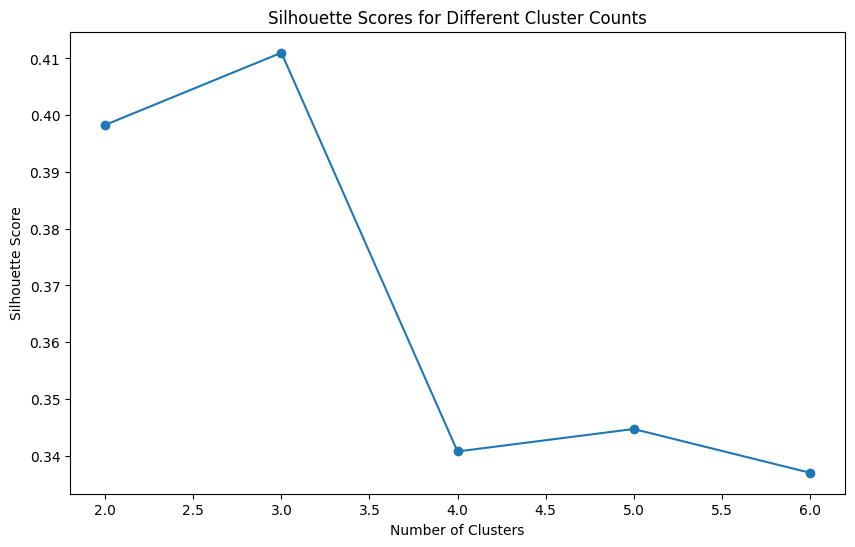

In [36]:
#Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]

silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title("Silhouette Scores for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.39829546318956227
For n_clusters = 3, the average silhouette_score is : 0.41101747014819345
For n_clusters = 4, the average silhouette_score is : 0.340733774473351
For n_clusters = 5, the average silhouette_score is : 0.344694202502736
For n_clusters = 6, the average silhouette_score is : 0.33698701902265654


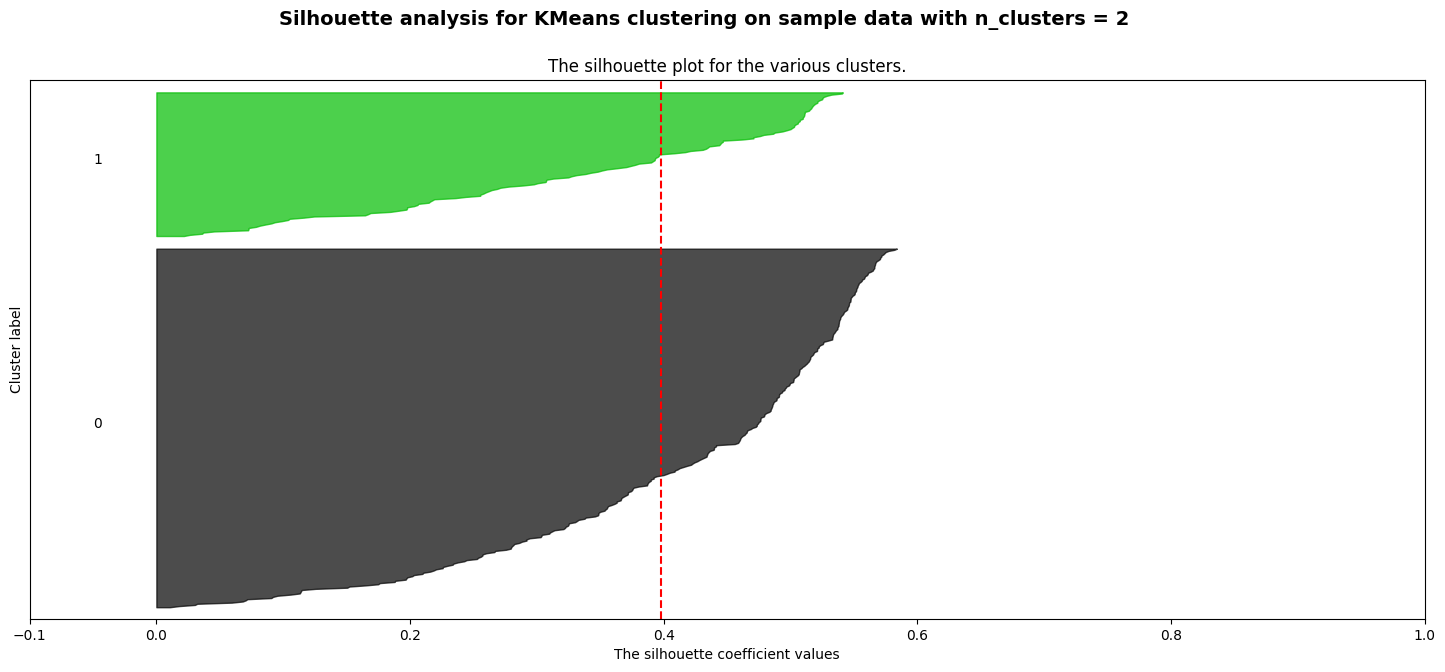

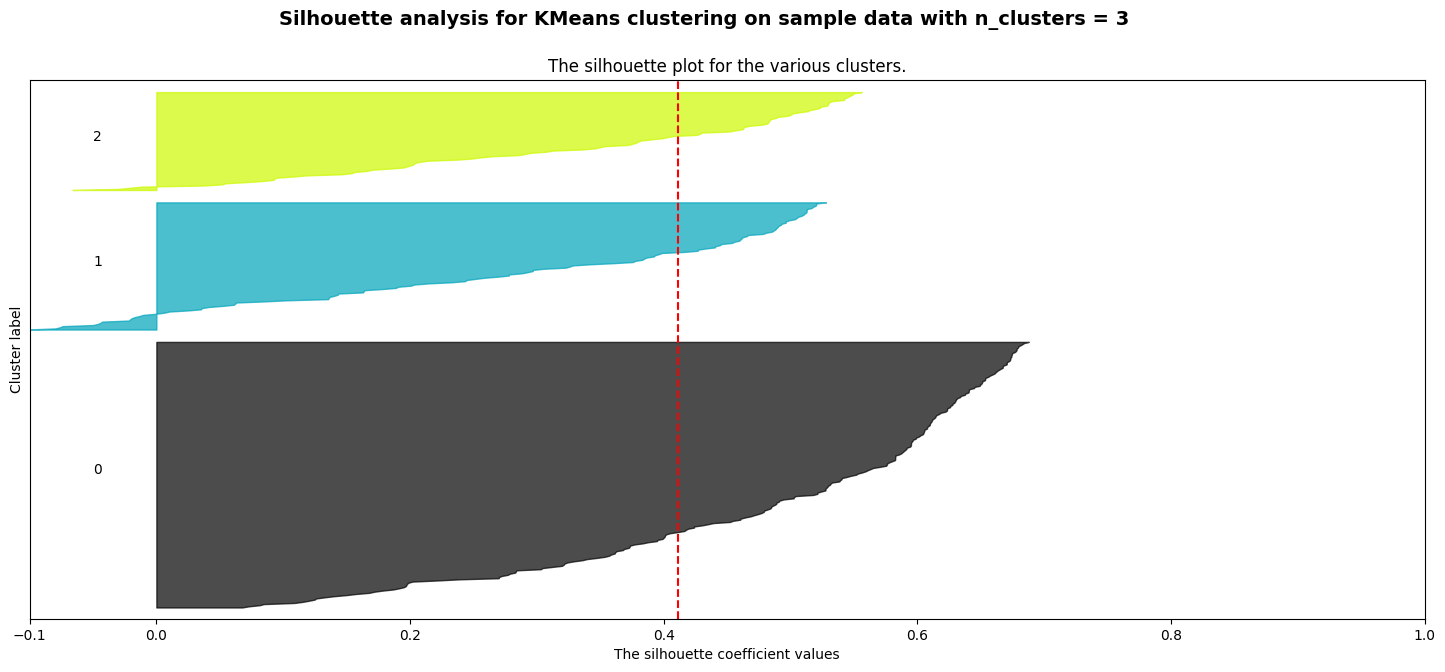

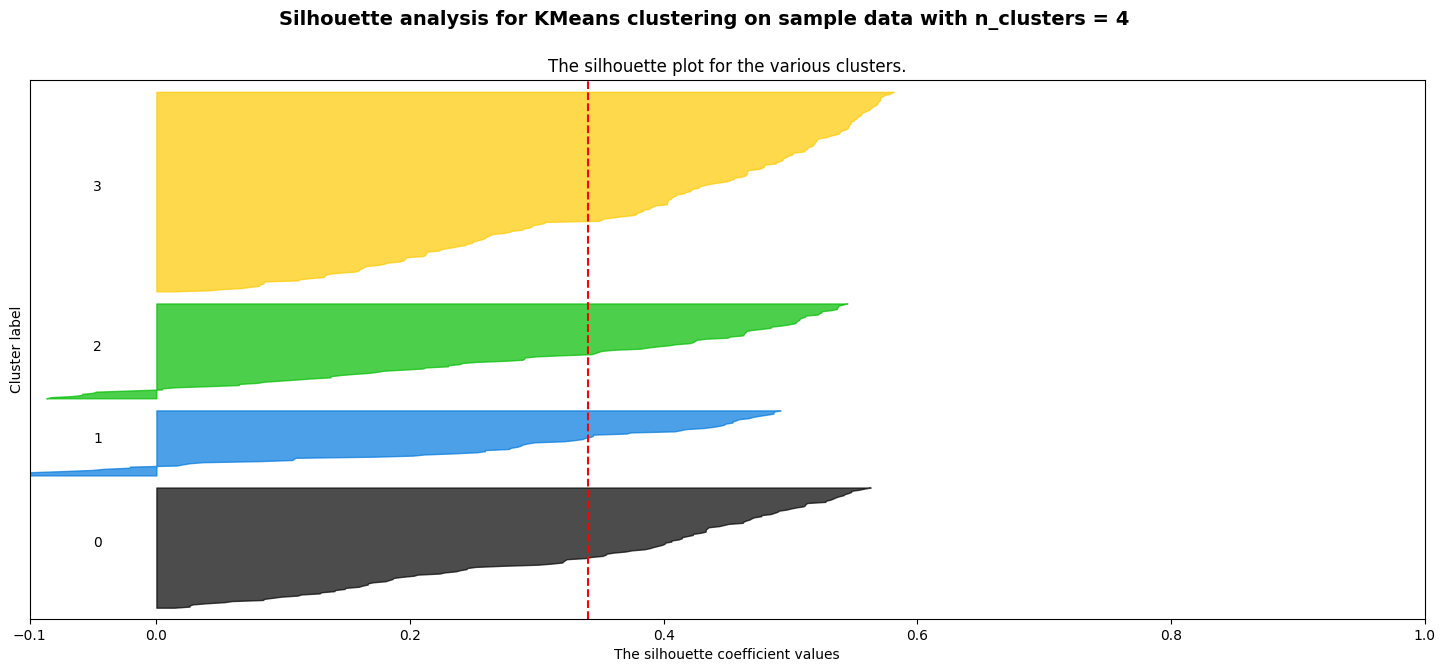

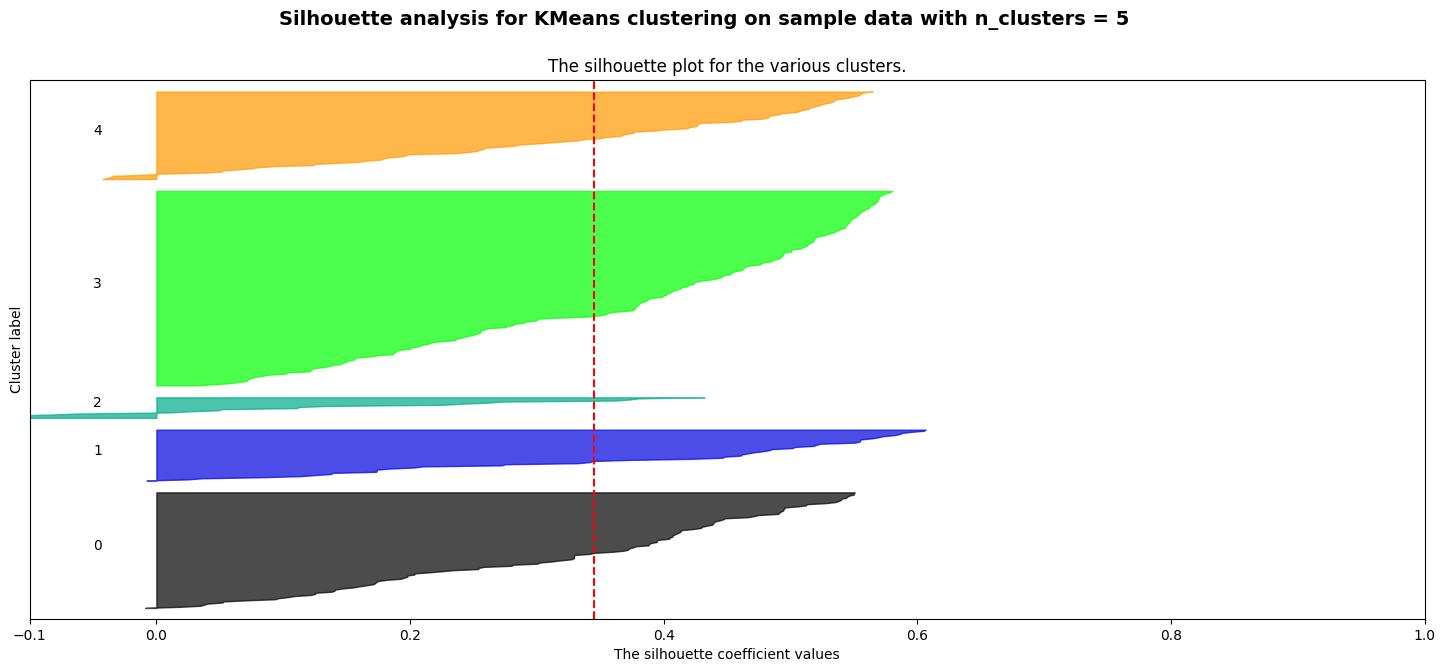

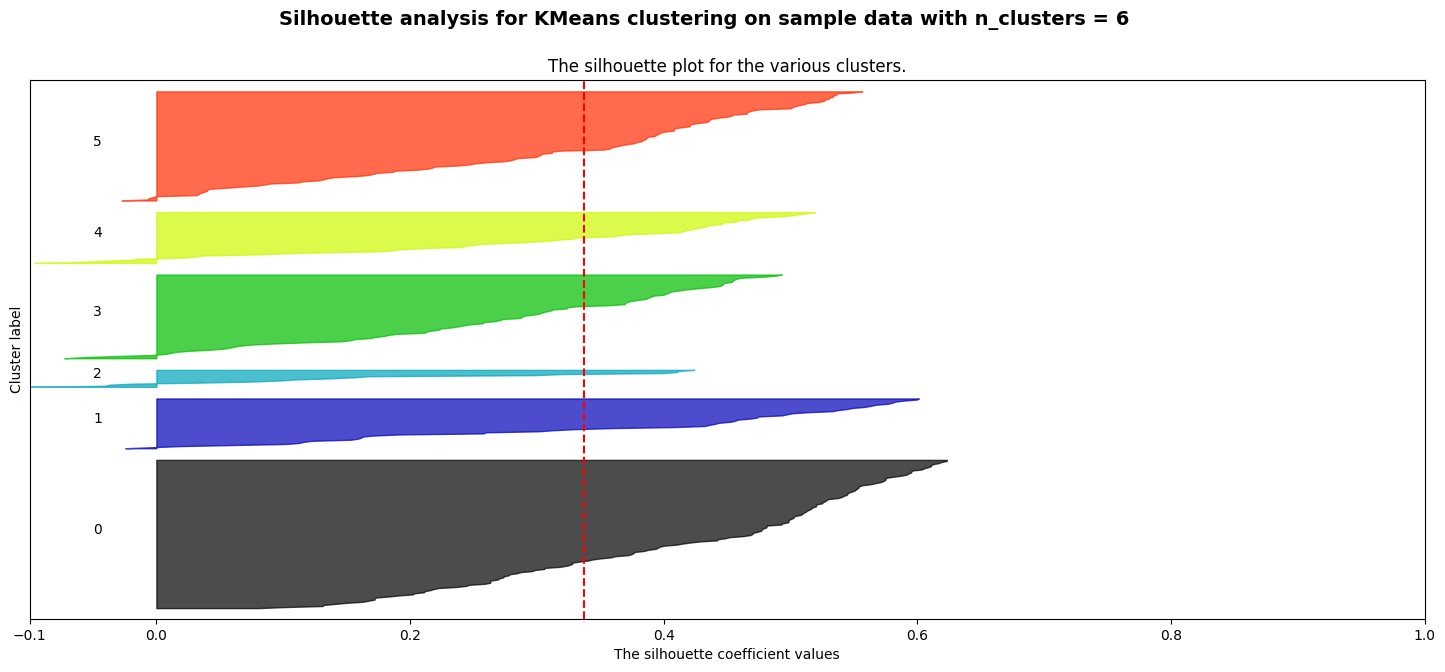

In [38]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in range_n_clusters:

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
   
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10   # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

As per the Silhouette Score, the optimal number of clusters is 3, as the Silhouette Score in k = 3 is the highest among other k values.

## Sales or marketing strategies for each customer segment

In [39]:
# run the clustering results with k = 3
df_3

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Cluster
0,online,Shenzhen,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,1
1,online,Shenzhen,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,1
2,online,Shenzhen,6353.0,8808.0,7684.0,2405.0,3516.0,4646.3,1
3,offline,Shenzhen,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,1
4,online,Shenzhen,22615.0,5410.0,7198.0,3915.0,1777.0,4646.3,0
...,...,...,...,...,...,...,...,...,...
435,offline,Shenzhen,29703.0,12051.0,16027.0,10017.3,182.0,2204.0,0
436,offline,Shenzhen,36865.9,1431.0,764.0,4510.0,93.0,2346.0,0
437,online,Shenzhen,14531.0,15488.0,24714.5,437.0,12237.0,1867.0,2
438,offline,Shenzhen,10290.0,1981.0,2232.0,1038.0,168.0,2125.0,1


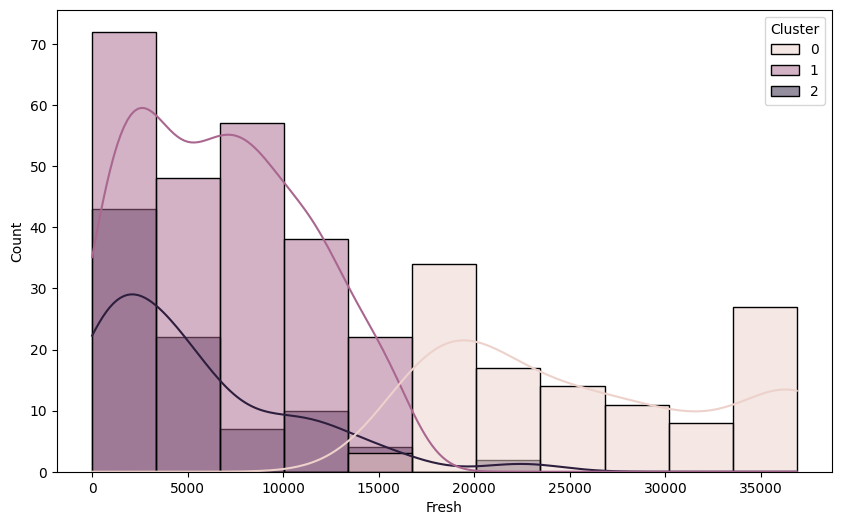

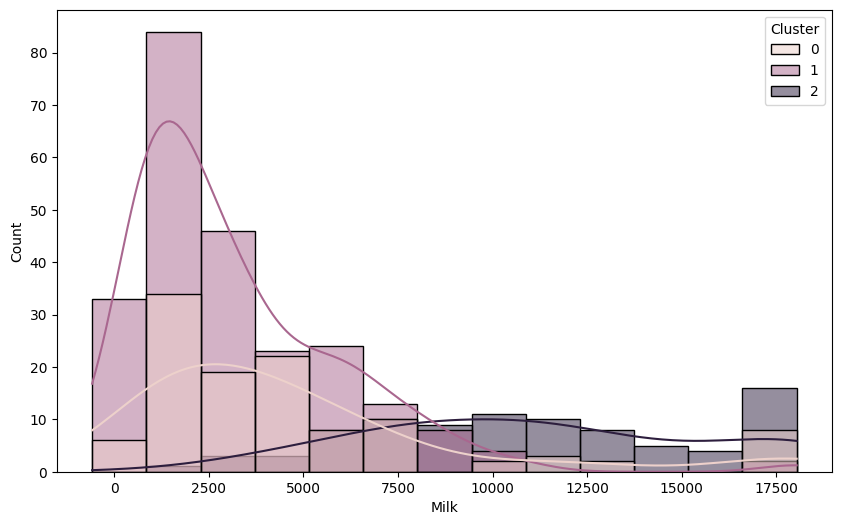

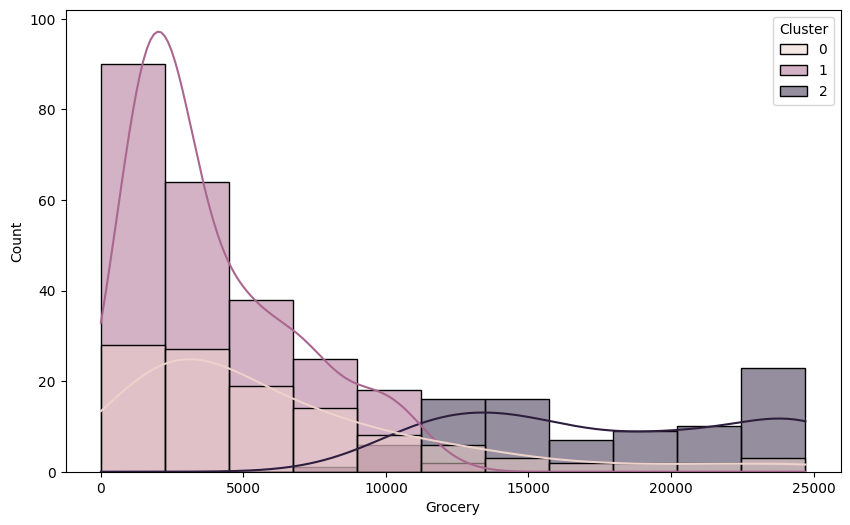

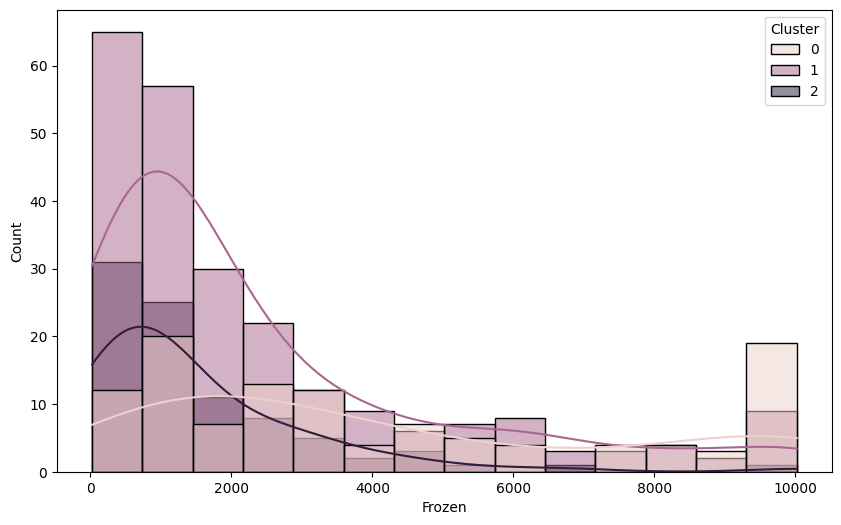

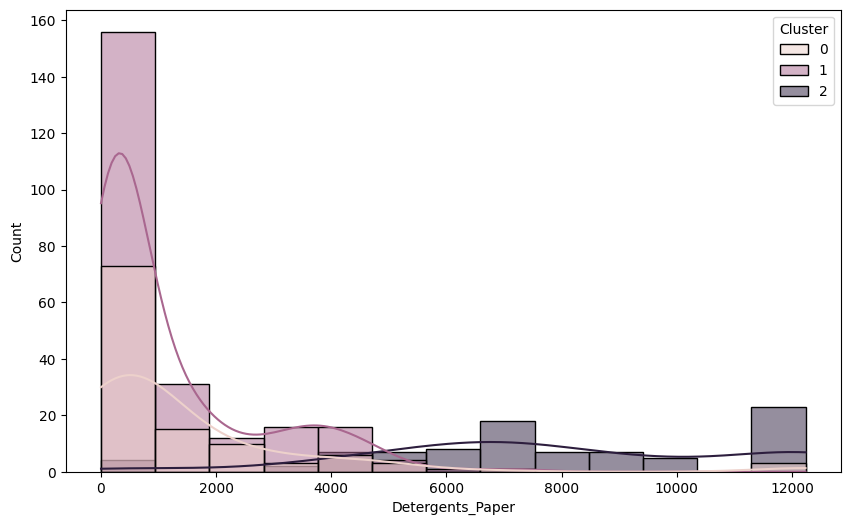

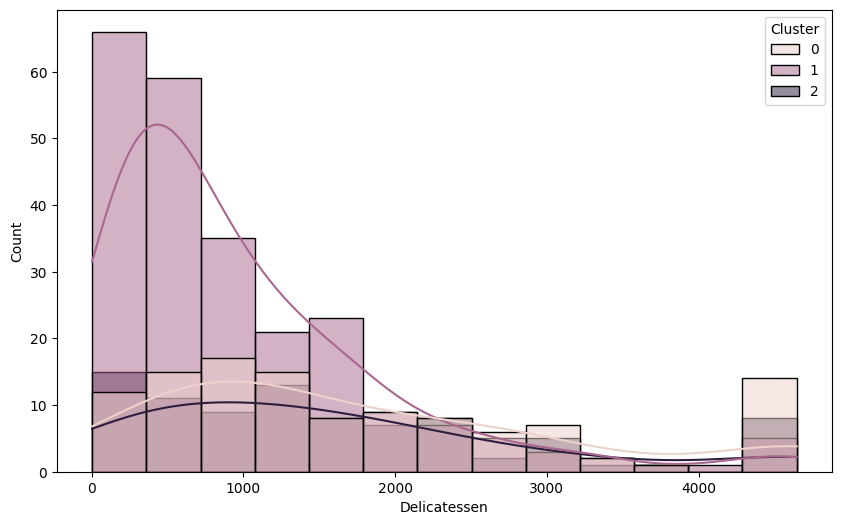

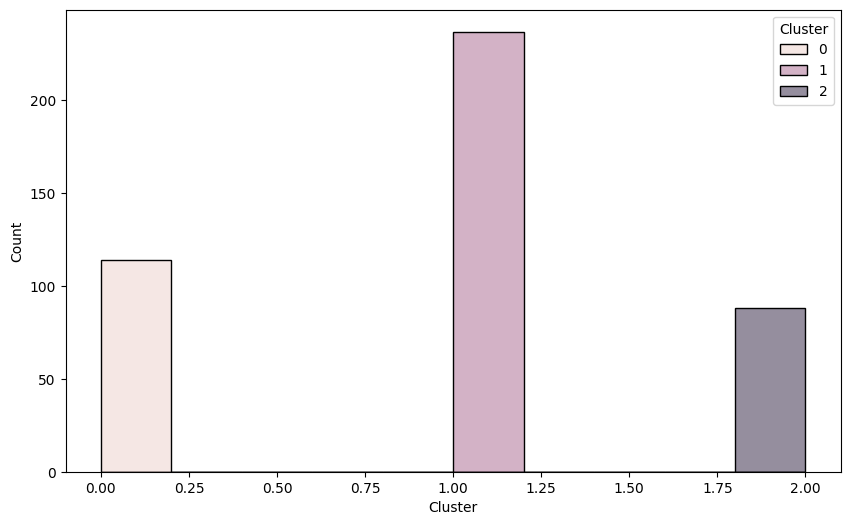

In [40]:
# generate histograms for each sales in each product in each cluster
for i in df_3.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_3, x=i, hue='Cluster', kde=True)
    plt.show()

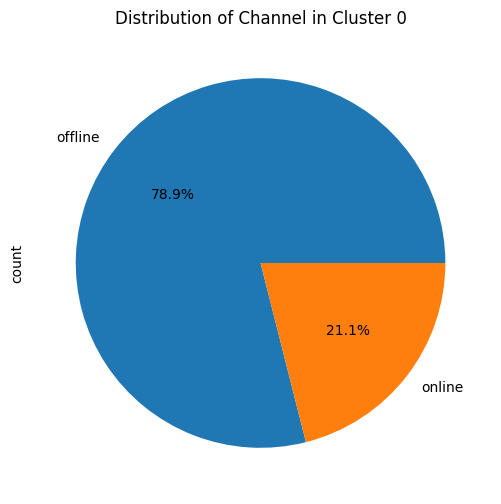

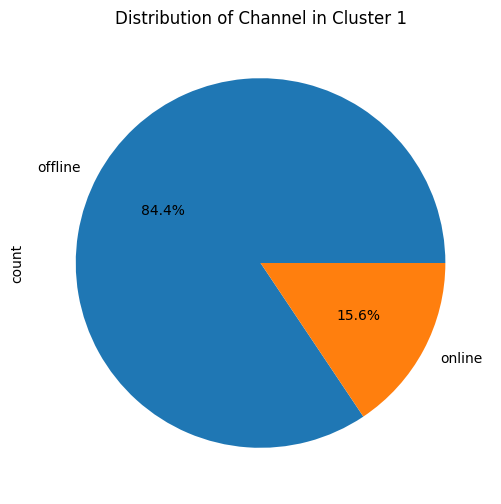

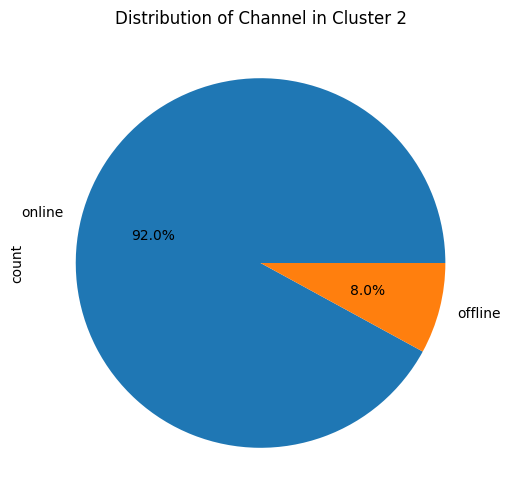

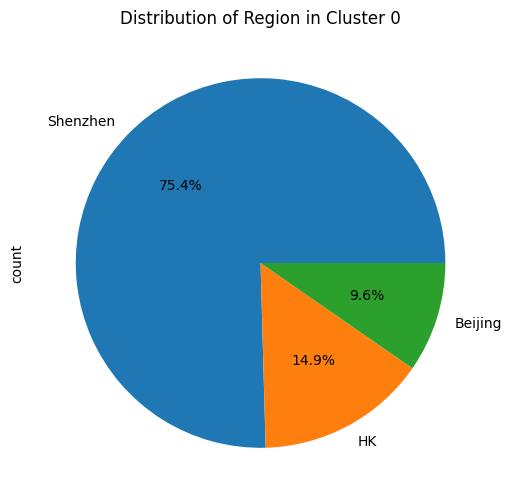

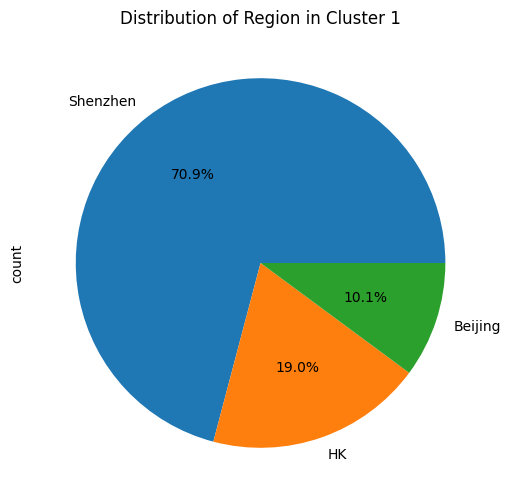

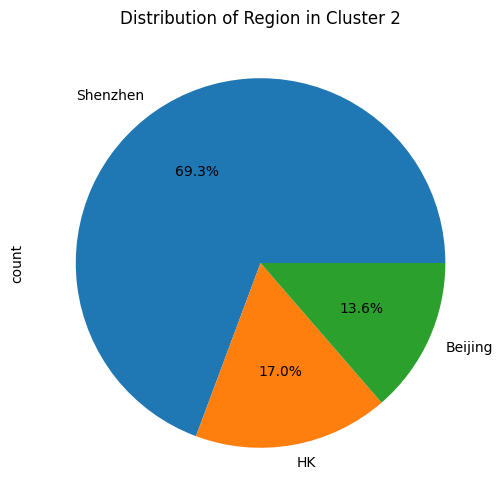

In [41]:
# generate pie charts for categorical data in each cluster
for i in df_3.select_dtypes(include='object').columns:
    plt.figure(figsize=(10, 6))
    df_3[i][df_3['Cluster'] == 0].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Distribution of {i} in Cluster 0')
    plt.show()

    plt.figure(figsize=(10, 6))
    df_3[i][df_3['Cluster'] == 1].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Distribution of {i} in Cluster 1')
    plt.show()

    plt.figure(figsize=(10, 6))
    df_3[i][df_3['Cluster'] == 2].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Distribution of {i} in Cluster 2')
    plt.show()

In [53]:
# summary statistics for each cluster
summary_df = df_3.groupby('Cluster').describe().T
summary_df

Cluster                            0             1             2
Fresh            count    114.000000    237.000000     88.000000
                 mean   25882.103509   6816.194093   5138.125000
                 std     7345.246878   4461.702379   5060.058420
                 min    16448.000000      3.000000     18.000000
                 25%    19056.250000   2886.000000   1184.250000
                 50%    24778.500000   6623.000000   3598.000000
                 75%    31787.500000  10253.000000   7531.500000
                 max    36865.900000  16260.000000  22925.000000
Milk             count    114.000000    237.000000     88.000000
                 mean    4840.282456   3208.287764  11134.034091
                 std     4475.311167   2787.216897   4491.815454
                 min      134.000000   -589.000000   1275.000000
                 25%     1785.250000   1110.000000   7697.250000
                 50%     3645.000000   2295.000000  10787.500000
                 75%     6206.000000   4859.000000  14701.000000
                 max    18041.200000  18041.200000  18041.200000
Grocery          count    114.000000    237.000000     88.000000
                 mean    6344.828947   3934.130802  17845.028409
                 std     5595.924027   2877.902670   5164.919562
                 min        3.000000    137.000000   8852.000000
                 25%     2373.000000   1733.000000  13379.250000
                 50%     4630.500000   2933.000000  17168.000000
                 75%     8421.750000   5615.000000  23244.250000
                 max    24714.500000  12400.000000  24714.500000
Frozen           count    114.000000    237.000000     88.000000
                 mean    4246.054386   2384.616456   1509.457955
                 std     3373.816947   2521.918824   1644.294106
                 min      118.000000     47.000000     25.000000
                 25%     1310.750000    659.000000    427.250000
                 50%     3045.500000   1393.000000    957.000000
                 75%     7359.000000   3151.000000   1941.250000
                 max    10017.300000  10017.300000  10017.300000
Detergents_Paper count    114.000000    237.000000     88.000000
                 mean    1460.745614   1148.635021   7883.159091
                 std     2257.918898   1437.059614   3207.893225
                 min        3.000000      3.000000    241.000000
                 25%      255.500000    200.000000   5955.750000
                 50%      601.500000    469.000000   7230.500000
                 75%     1678.000000   1538.000000  11628.500000
                 max    12237.000000   7271.000000  12237.000000
Delicatessen     count    114.000000    237.000000     88.000000
                 mean    1803.408772    981.024895   1607.319318
                 std     1371.031601    934.270762   1305.466374
                 min        3.000000      3.000000      3.000000
                 25%      797.000000    323.000000    692.000000
                 50%     1387.500000    689.000000   1317.500000
                 75%     2592.500000   1371.000000   2171.750000
                 max     4646.300000   4646.300000   4646.300000

Text(0.5, 1.0, 'Distribution of Clusters')

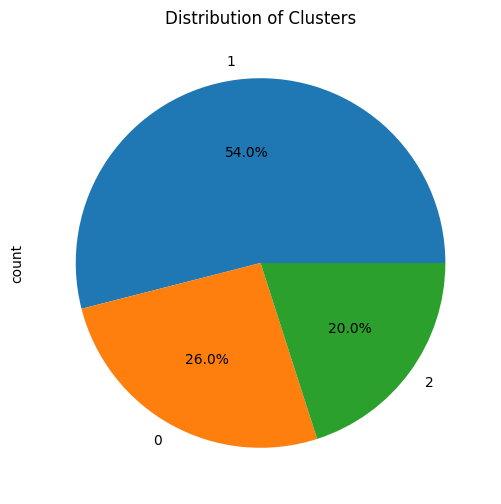

In [55]:
# distribution of clusters in %, visualize with pie chart
plt.figure(figsize=(10, 6))
df_3['Cluster'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Clusters')

Here are the characteristics of each customer segment:

* Cluster 0: This cluster takes 26% in total customers. This type of customer having the highest mean of purchase of Fresh, Frozen, Detergents_Paper, and Delicatessen. This type of customer is more likely to be a restaurant or cafe.

* Cluster 1: This cluster takes 54% in total customers, averagely speaking this type of customer has a relative lower amount of purchase in all categories. They may be small retailers or small grocery stores.

* Cluster 2: This cluster takes 20% in total customers, this type of customer has the highest mean of purchase in Milk and Grocery. They may be large retailers or large grocery stores.


Suggestions for sales or marketing strategies for each customer segment:

* Cluster 0: As this type of customer is more likely to be a restaurant or cafe, the wholesale distributor can provide a bundle discount of Fresh, Frozen, Detergents_Paper, and Delicatessen to encourage them to purchase more.

* Cluster 1: As this type of customer may be small retailers or small grocery stores and they're more sensitive to the price of products, the wholesale distributor can retain customer loyalty with a long-term customer discount program.

* Cluster 2: As this type of customer may be large retailers or large grocery stores, the wholesale distributor can provide a bundle discount of Milk and Grocery, to encourage them to purchase more.